# Fishing Effort in the Seychelles EEZ

In [4]:

import bq  
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import matplotlib.dates as mdates

client = bq.Client.Get()

In [38]:
# create a bounding box:
max_lat = 3
min_lat = -17
max_lon = 61.5
min_lon = 40
distance_from_shore_filter = 10 # in nautical miles
EEZ = 'Seychelles'


In [39]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [48]:
q = '''
select count(distinct mmsi) 
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5
  AND JSON_EXTRACT(extra,"$.eez") = '"EEZ:'''+EEZ+'''"'
  and float(JSON_EXTRACT(EXTRA,"$.distance_to_shore")) > '''+str(distance_from_shore_filter)+'''
  '''
number_of_mmsi = Query(q)

Waiting on bqjob_r668c3e665b3946e0_00000153e7115435_16 ... (23s) Current status: DONE   
Query time: 25.6048569679 seconds.


In [49]:
print "Number of unique MMSI:",int(number_of_mmsi[0][0])

Number of unique MMSI: 79


# 79 MMSI were fishing in this region from January 2014 to July 2015

In [50]:
q = '''
select a.mmsi mmsi,
a.number number,
if(b.country is null, "invalid mmsi",b.country) country,
b.continent continent
from
(select mmsi, 
integer(if(length(string(mmsi))= 9,LEFT(STRING(mmsi),3), '0')) code,
count(*) number from
(SELECT
  mmsi,
  date(timestamp) date,
  first(latitude) lat,
  first(longitude) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > -15
  AND latitude <-5
  AND longitude > 55
  AND longitude <65
  AND weight >=.5
  AND JSON_EXTRACT(extra,"$.eez") = '"EEZ:'''+EEZ+'''"'
  and float(JSON_EXTRACT(EXTRA,"$.distance_to_shore")) > '''+str(distance_from_shore_filter)+'''


group by mmsi, date) 
group by mmsi, code 
) 
a
left join [scratch_roan.country_code] b
on a.code = b.code 
order by number desc'''

days_by_mmsi = Query(q)

Waiting on bqjob_r6027e0a2b942d368_00000153e7123e6f_17 ... (34s) Current status: DONE   
Query time: 37.4878251553 seconds.


# The List of MMSI that were fishing are below

In [51]:
for r in days_by_mmsi:
    if "Taiwan" in r[2]:
        r[2] = "Taiwan"
    print "mmsi:", r[0],"  fishing days:", r[1], "  country: ", r[2].split(" (")[0]

mmsi: 664544000   fishing days: 19   country:  Seychelles
mmsi: 416768000   fishing days: 18   country:  Taiwan
mmsi: 660004300   fishing days: 16   country:  Reunion
mmsi: 247354400   fishing days: 15   country:  Italy
mmsi: 660005100   fishing days: 11   country:  Reunion
mmsi: 416004773   fishing days: 11   country:  Taiwan
mmsi: 416556000   fishing days: 10   country:  Taiwan
mmsi: 412695690   fishing days: 10   country:  China
mmsi: 416004790   fishing days: 9   country:  Taiwan
mmsi: 416241800   fishing days: 9   country:  Taiwan
mmsi: 224069690   fishing days: 9   country:  Spain
mmsi: 416803000   fishing days: 9   country:  Taiwan
mmsi: 660004900   fishing days: 8   country:  Reunion
mmsi: 416333000   fishing days: 8   country:  Taiwan
mmsi: 440822000   fishing days: 7   country:  Korea
mmsi: 412695710   fishing days: 6   country:  China
mmsi: 660001900   fishing days: 6   country:  Reunion
mmsi: 548055100   fishing days: 6   country:  Philippines
mmsi: 441734000   fishing days

In [52]:
# Now Group by Country
q = '''
SELECT 
country,
sum(number) number
from
(select a.mmsi mmsi,
a.number number,
if(b.country is null, "invalid mmsi",b.country) country,
b.continent continent
from
(select mmsi, 
integer(if(length(string(mmsi))= 9,LEFT(STRING(mmsi),3), '0')) code,
count(*) number from
(SELECT
  mmsi,
  date(timestamp) date,
  first(latitude) lat,
  first(longitude) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5
  AND JSON_EXTRACT(extra,"$.eez") = '"EEZ:'''+EEZ+'''"'
  and float(JSON_EXTRACT(EXTRA,"$.distance_to_shore")) > '''+str(distance_from_shore_filter)+'''

  group by mmsi, date) 
group by mmsi, code 
) 
a
left join [scratch_roan.country_code] b
on a.code = b.code)
group by country
order by number desc'''

country_groups = Query(q)

Waiting on bqjob_r650a7d7475a3d06f_00000153e712d0ee_18 ... (34s) Current status: DONE   
Query time: 37.1115729809 seconds.


In [53]:
print "days\tcountry"
for c in country_groups:
    print c[1],'\t', c[0].split(" (")[0]

days	country
546 	Taiwan
315 	Seychelles
194 	Korea
169 	China
166 	Reunion
54 	Spain
43 	Thailand
27 	Italy
23 	France
9 	Indonesia
6 	Philippines
5 	invalid mmsi
4 	Japan
4 	Mauritius
1 	Panama


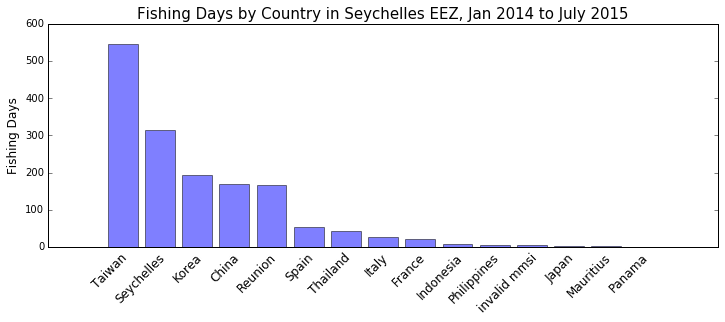

In [54]:
objects = [c[0].split(" (")[0] for c in country_groups]
y_pos = np.arange(len(objects))
performance = [c[1] for c in country_groups]
 
plt.figure(figsize=(12,4))
plt.bar(y_pos-4, performance, align='center', alpha=0.5,)
plt.xticks(y_pos-4+.2, objects, fontsize=12) # rotation=45
locs, labels = plt.xticks()
plt.setp(labels, rotation=45,ha='right')
plt.ylabel('Fishing Days',fontsize=12)
plt.title('Fishing Days by Country in Seychelles EEZ, Jan 2014 to July 2015',fontsize=15)

ax = plt.axes()
ax.xaxis.set_ticks_position('none') 
plt.savefig("fishing_effort_seychelles_by_Country.png",bbox_inches='tight',dpi=150,transparent=True,pad_inches=.1)
plt.show()

# Map the Fishing Effort in This Region

In [55]:
# Now Group by Country
q = '''
SELECT
lat,
lon,
count(*) fishing_days
from
(SELECT
  mmsi,
  date(timestamp) date,
  integer(first(latitude)*4) lat,
  integer(first(longitude)*4) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5
  AND JSON_EXTRACT(extra,"$.eez") = '"EEZ:'''+EEZ+'''"'
  and float(JSON_EXTRACT(EXTRA,"$.distance_to_shore")) > '''+str(distance_from_shore_filter)+'''
  group by mmsi, date) 
group by lat, lon
'''

fishing_grid = Query(q)

Waiting on bqjob_r64cf9a9ce05ba58_00000153e71364ea_19 ... (34s) Current status: DONE   
Query time: 36.9602999687 seconds.


In [56]:
cellsize = .25
one_over_cellsize = 4

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1


grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = int(row[2])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


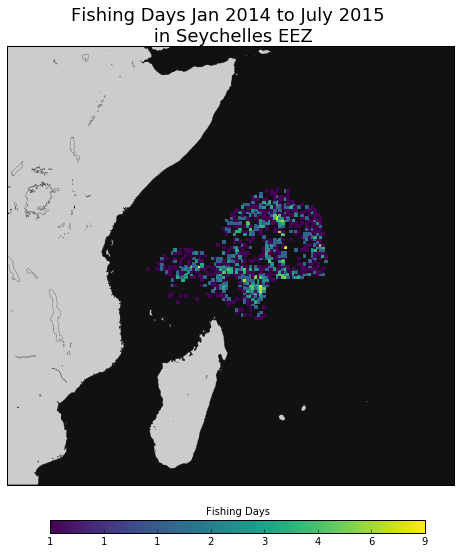

In [58]:
plt.rcParams["figure.figsize"] = [8,9]

firstlat = max_lat
lastlat =  min_lat
firstlon = min_lon
lastlon = max_lon
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
extra = 10
m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
          llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary(fill_color='#111111')
m.drawcoastlines(linewidth=.2)
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)

x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Days Jan 2014 to July 2015 \n in Seychelles EEZ"
plt.title(t, color = "#000000", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.65, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Days',labelpad=-40, y=0.45, color = "#000000")
plt.savefig("fishing_effort_seychelles.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()

In [59]:
# Now fishing days outside the EEZ
q = '''
SELECT
lat,
lon,
count(*) fishing_days
from
(SELECT
  mmsi,
  date(timestamp) date,
  integer(first(latitude)*4) lat,
  integer(first(longitude)*4) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5
  AND JSON_EXTRACT(extra,"$.eez") != '"EEZ:'''+EEZ+'''"'
  and float(JSON_EXTRACT(EXTRA,"$.distance_to_shore")) > '''+str(distance_from_shore_filter)+'''
  group by mmsi, date) 
group by lat, lon
'''

fishing_grid = Query(q)

Waiting on bqjob_r4730e290db836f61_00000153e725fc5d_20 ... (15s) Current status: DONE   
Query time: 18.7124450207 seconds.


In [60]:
cellsize = .25
one_over_cellsize = 4

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1


grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = int(row[2])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


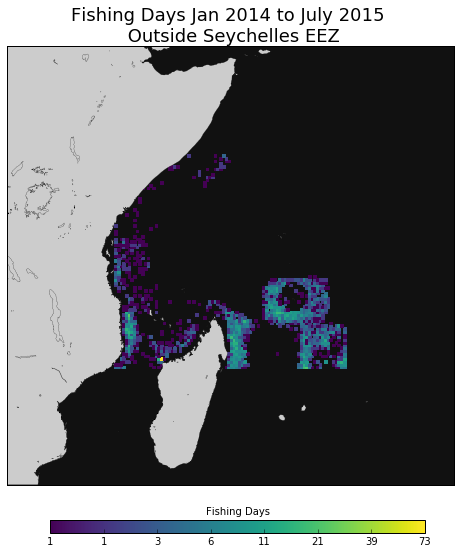

In [61]:
plt.rcParams["figure.figsize"] = [8,9]

firstlat = max_lat
lastlat =  min_lat
firstlon = min_lon
lastlon = max_lon
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
extra = 10
m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
          llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary(fill_color='#111111')
m.drawcoastlines(linewidth=.2)
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)

x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Days Jan 2014 to July 2015 \n Outside Seychelles EEZ"
plt.title(t, color = "#000000", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.65, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Days',labelpad=-40, y=0.45, color = "#000000")
plt.savefig("fishing_effort_outside_seychelles.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()

In [62]:
# Now fishing days outside the EEZ
q = '''
SELECT
lat,
lon,
count(*) fishing_days
from
(SELECT
  mmsi,
  date(timestamp) date,
  integer(first(latitude)*4) lat,
  integer(first(longitude)*4) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5
  //AND JSON_EXTRACT(extra,"$.eez") != '"EEZ:'''+EEZ+'''"'
  and float(JSON_EXTRACT(EXTRA,"$.distance_to_shore")) > '''+str(distance_from_shore_filter)+'''
  group by mmsi, date) 
group by lat, lon
'''

fishing_grid = Query(q)

Waiting on bqjob_r409a8f6c2cc2393c_00000153e740c1c4_21 ... (23s) Current status: DONE   
Query time: 27.3496830463 seconds.


In [63]:
cellsize = .25
one_over_cellsize = 4

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1


grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = int(row[2])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


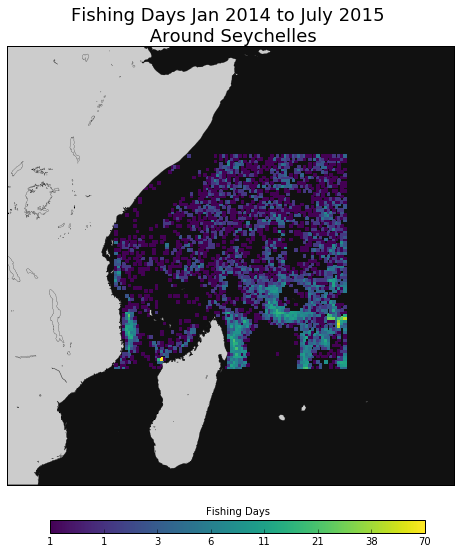

In [64]:
plt.rcParams["figure.figsize"] = [8,9]

firstlat = max_lat
lastlat =  min_lat
firstlon = min_lon
lastlon = max_lon
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
extra = 10
m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
          llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary(fill_color='#111111')
m.drawcoastlines(linewidth=.2)
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)

x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Days Jan 2014 to July 2015 \n Around Seychelles"
plt.title(t, color = "#000000", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.65, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Days',labelpad=-40, y=0.45, color = "#000000")
plt.savefig("fishing_effort_outside_and_indside_seychelles.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()